In [ ]:
!pip install pfrl
!pip install Box2D
!pip install gym[Box_2D]

     |████████████████████████████████| 108 kB 31.7 MB/s 
  Created wheel for pfrl: filename=pfrl-0.3.0-py3-none-any.whl size=155103 sha256=183e883e4142abfe849e064f69837c4072e9b0154b395d5a07ab6e277881b9a9
  Stored in directory: /root/.cache/pip/wheels/22/bd/8c/fa211f1fe771c55a31b756c3125e81b15c4ec6f93ff07e6270
Successfully built pfrl
     |████████████████████████████████| 1.3 MB 9.0 MB/s 


Part 1: Cartpole

In [ ]:
print(numpy.linspace(0, 1, num = 11))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
initial observation: [ 0.0401285   0.01703551 -0.00740102 -0.00361632]
next observation: [ 0.04046921 -0.17797952 -0.00747334  0.28672234]
reward: 1.0
done: False
info: {}


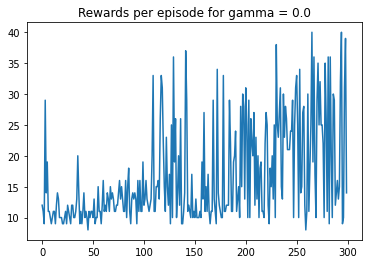

Finished.


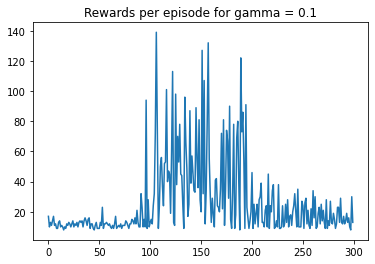

Finished.


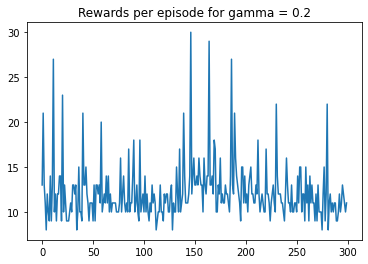

Finished.


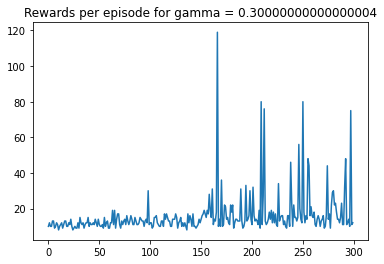

Finished.


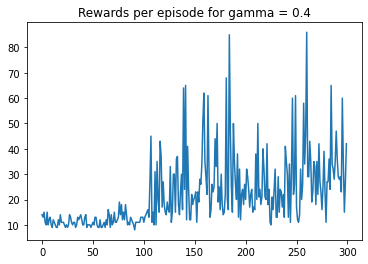

Finished.


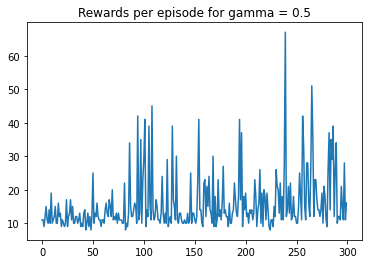

Finished.


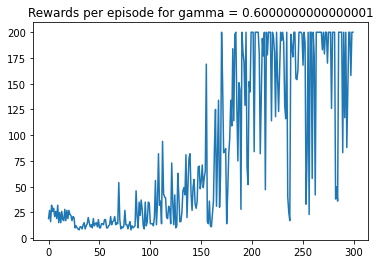

Finished.


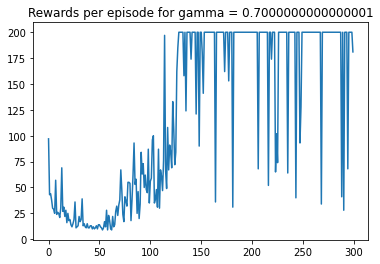

Finished.


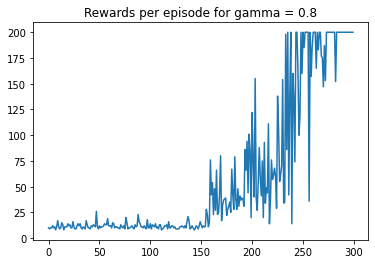

Finished.


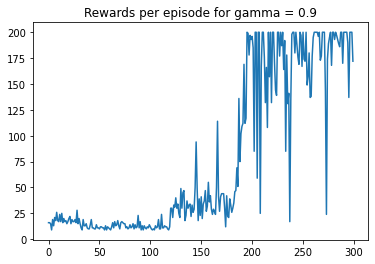

Finished.


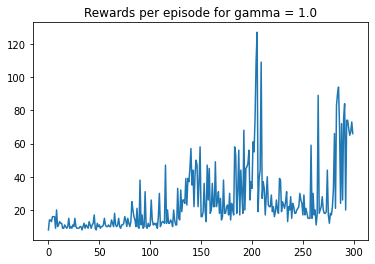

Finished.


In [ ]:
import pfrl
import torch
import torch.nn
import gym
import numpy
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

gammas = numpy.linspace(0, 1, num = 11)

for gamma in gammas:

  class QFunction(torch.nn.Module):

      def __init__(self, obs_size, n_actions):
          super().__init__()
          self.l1 = torch.nn.Linear(obs_size, 50)
          self.l2 = torch.nn.Linear(50, 50)
          self.l3 = torch.nn.Linear(50, n_actions)

      def forward(self, x):
          h = x
          h = torch.nn.functional.relu(self.l1(h))
          h = torch.nn.functional.relu(self.l2(h))
          h = self.l3(h)
          return pfrl.action_value.DiscreteActionValue(h)

  obs_size = env.observation_space.low.size
  n_actions = env.action_space.n
  q_func = QFunction(obs_size, n_actions)

  optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-2)

  # gamma = 0.9

  # Use epsilon-greedy for exploration
  explorer = pfrl.explorers.ConstantEpsilonGreedy(
      epsilon=0.3, random_action_func=env.action_space.sample)

  # DQN uses Experience Replay.
  # Specify a replay buffer and its capacity.
  replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10 ** 6)

  # Since observations from CartPole-v0 is numpy.float64 while
  # As PyTorch only accepts numpy.float32 by default, specify
  # a converter as a feature extractor function phi.
  phi = lambda x: x.astype(numpy.float32, copy=False)

  # Set the device id to use GPU. To use CPU only, set it to -1.
  gpu = -1

  # Now create an agent that will interact with the environment.
  agent = pfrl.agents.DoubleDQN(
      q_func,
      optimizer,
      replay_buffer,
      gamma,
      explorer,
      replay_start_size=500,
      update_interval=1,
      target_update_interval=100,
      phi=phi,
      gpu=gpu,
  )

  n_episodes = 300
  max_episode_len = 200

  rewards_list = []
  for i in range(1, n_episodes + 1):
      obs = env.reset()
      R = 0  # return (sum of rewards)
      t = 0  # time step

      while True:
          # Uncomment to watch the behavior in a GUI window
          # env.render()
          action = agent.act(obs)
          obs, reward, done, _ = env.step(action)
          R += reward
          t += 1
          reset = t == max_episode_len
          agent.observe(obs, reward, done, reset)
          if done or reset:
              break
      '''
      if i % 10 == 0:
          # print('episode:', i, 'R:', R)
      if i % 50 == 0:
          # print('statistics:', agent.get_statistics())
      '''

      rewards_list.append(R)

  # print(rewards_list)

  plt.plot(rewards_list)
  plt.title(f'Rewards per episode for gamma = {gamma}')
  plt.show()

  print('Finished.')


Part 1: Cartpole, but longer training to evaluate stability

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
initial observation: [ 0.03790151  0.04285194 -0.03860175  0.02272787]
next observation: [ 0.03875855 -0.15169577 -0.0381472   0.30298595]
reward: 1.0
done: False
info: {}


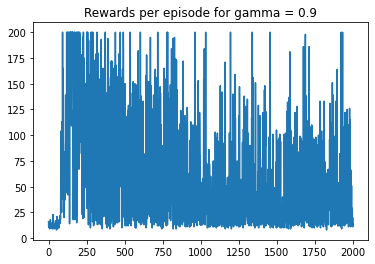

Finished.


In [4]:
import pfrl
import torch
import torch.nn
import gym
import numpy
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

# Use only one gamma
gammas = [0.9]

for gamma in gammas:

  class QFunction(torch.nn.Module):

      def __init__(self, obs_size, n_actions):
          super().__init__()
          self.l1 = torch.nn.Linear(obs_size, 50)
          self.l2 = torch.nn.Linear(50, 50)
          self.l3 = torch.nn.Linear(50, n_actions)

      def forward(self, x):
          h = x
          h = torch.nn.functional.relu(self.l1(h))
          h = torch.nn.functional.relu(self.l2(h))
          h = self.l3(h)
          return pfrl.action_value.DiscreteActionValue(h)

  obs_size = env.observation_space.low.size
  n_actions = env.action_space.n
  q_func = QFunction(obs_size, n_actions)

  optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-2)

  # gamma = 0.9

  # Use epsilon-greedy for exploration
  explorer = pfrl.explorers.ConstantEpsilonGreedy(
      epsilon=0.3, random_action_func=env.action_space.sample)

  # DQN uses Experience Replay.
  # Specify a replay buffer and its capacity.
  replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10 ** 6)

  # Since observations from CartPole-v0 is numpy.float64 while
  # As PyTorch only accepts numpy.float32 by default, specify
  # a converter as a feature extractor function phi.
  phi = lambda x: x.astype(numpy.float32, copy=False)

  # Set the device id to use GPU. To use CPU only, set it to -1.
  gpu = -1

  # Now create an agent that will interact with the environment.
  agent = pfrl.agents.DoubleDQN(
      q_func,
      optimizer,
      replay_buffer,
      gamma,
      explorer,
      replay_start_size=500,
      update_interval=1,
      target_update_interval=100,
      phi=phi,
      gpu=gpu,
  )

  n_episodes = 2000
  max_episode_len = 200

  rewards_list = []
  for i in range(1, n_episodes + 1):
      obs = env.reset()
      R = 0  # return (sum of rewards)
      t = 0  # time step

      while True:
          # Uncomment to watch the behavior in a GUI window
          # env.render()
          action = agent.act(obs)
          obs, reward, done, _ = env.step(action)
          R += reward
          t += 1
          reset = t == max_episode_len
          agent.observe(obs, reward, done, reset)
          if done or reset:
              break
      '''
      if i % 10 == 0:
          # print('episode:', i, 'R:', R)
      if i % 50 == 0:
          # print('statistics:', agent.get_statistics())
      '''

      rewards_list.append(R)

  # print(rewards_list)

  plt.plot(rewards_list)
  plt.title(f'Rewards per episode for gamma = {gamma}')
  plt.show()

  print('Finished.')
